In [1]:
from torchvision import *
import torch
import torch.optim as optim
from model import SplittedResNet18
from IPython.display import display
from loss import CrossEntropyOSLoss
from utils.visual import imshow,visualize_model
from train import Trainer
import torch.nn as nn

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,6)
model = model.to(device)

splited_model = SplittedResNet18(model=model)

/Users/eda/.local/share/virtualenvs/b4-train-model-1AHW0aSJ/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/eda/.local/share/virtualenvs/b4-train-model-1AHW0aSJ/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
alpha = 0.01
loss_function = CrossEntropyOSLoss(alpha)

In [3]:
data_transforms = {
    "train":transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    "val":transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

data_dir = "./data"
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
                  for x in ["train","val"]}

dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=16,shuffle=True,num_workers=4)
                for x in ["train","val"]}
dataset_sizes = {x:len(image_datasets[x]) for x in ["train","val"]}
class_names = image_datasets["train"].classes

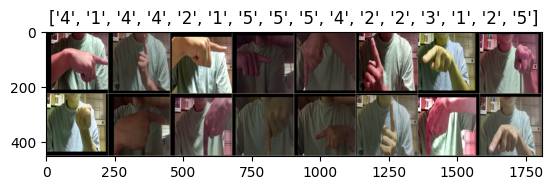

In [4]:
inputs,classes = next(iter(dataloaders["train"]))
out = utils.make_grid(inputs)
imshow(out,title=[class_names[x] for x in classes],mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])

In [5]:
from torch.optim import lr_scheduler

optimizer_ft = optim.SGD(splited_model.parameters(),lr=0.001,momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
trainer = Trainer(splited_model, loss_function, optimizer_ft, exp_lr_scheduler, dataloaders,dataset_sizes,device,num_epochs=2)
model = trainer.train()

Epoch 0/1
----------
train Loss: 0.4256 Acc: 0.9522
val Loss: 0.2460 Acc: 1.0000

Epoch 1/1
----------
train Loss: 0.2507 Acc: 0.9996
val Loss: 0.2431 Acc: 1.0000

Training complete in 15m 12s
Best val Acc: 1.000000


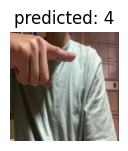

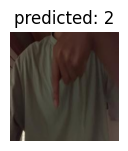

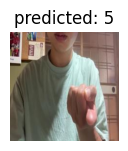

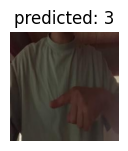

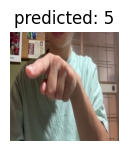

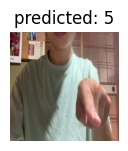

In [7]:
visualize_model(model=model,class_names=class_names,dataloaders=dataloaders,device=device,num_images=6)